In [16]:
import json
import math
import numpy as np

import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

import matplotlib.pyplot as plt
import os

import string
from gensim.models import Word2Vec

----------------------------------------------------------------------------------------

# PEOPLE

### Word2Vec

**Lecture fichier**

In [17]:
# name of the lightest file
file_name = "./jsonBases/topaz-data732--mali--www.egaliteetreconciliation.fr--20190101--20211231.json"

# open and load file
f = open(file_name, 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

**Ponctuations**

In [18]:
ponctuations = list(string.punctuation)
ponctuations.append('’')

**Recréation des articles avec seulement les mots importants et dans leur forme simple**

In [19]:
docFinal = []
key='kws'
tabWord = []

for annee in data["data-all"]:
    for mois in data["data-all"][annee]:
        for article in data["data-all"][annee][mois]:
            dat = data["data-all"][annee][mois][article][0]['content'].split()
            dat = [doc.lower() for doc in dat]
            nDat = []
            for mot in dat:
                nMot = mot
                for l in mot:
                    if l in ponctuations:
                        if l == mot[0] or l == mot[len(mot) - 1]:
                            nMot = nMot.replace(l, "")
                        else:
                            indice = mot.index(l)
                            nMot = mot.replace(l, "")
                            nMot = mot[:indice - 1] + mot[indice + 1:]

                if nMot in data["data-all"][annee][mois][article][0][key]:
                    nDat.append(nMot)
                    if nMot not in tabWord :
                        tabWord.append(nMot)
            docFinal.append(nDat)

documents = [" ".join(doc) for doc in docFinal]
print(documents[0])
print(tabWord)

burkina faso violence djihadiste mardi attaque arbinda nord pays histoire pays deuil national président burkinabé roch kaboré personne compte twitter attaque barbare chef état burkinabé manque poigne face roch kaboré mardi matin détachement militaire arbinda province soum attaque rare intensité armée burkinabée fuite gouvernement soirée mardi décembre dizaine attaque hallalé pays pauvre afrique ouest niger mali début novembre société attaque convoi burkina nord pays décompte afp bilan février dernier peur soum opération sahel preuve situation expert militaire tiers burkina faso nord sud gars moto expert militaire article entier
['burkina', 'faso', 'violence', 'djihadiste', 'mardi', 'attaque', 'arbinda', 'nord', 'pays', 'histoire', 'deuil', 'national', 'président', 'burkinabé', 'roch', 'kaboré', 'personne', 'compte', 'twitter', 'barbare', 'chef', 'état', 'manque', 'poigne', 'face', 'matin', 'détachement', 'militaire', 'province', 'soum', 'rare', 'intensité', 'armée', 'burkinabée', 'fuit

**Création du modèle word2vec avec 2 dimensions**

In [20]:
modele = Word2Vec(docFinal, vector_size=2, window=5)

**Vectorisation des mots**

In [21]:
words = modele.wv

**Similarité entre 2 mots**

In [22]:
mot1 = "mali"
mot2 = "attaque"
print(words.similarity(mot1, mot2))

0.9928995


**Mots les plus proches d'un autre**

In [23]:
mot = "mali"
print(words.most_similar(mot))

[('compte', 1.0), ('vie', 0.9999998807907104), ('irak', 0.999999463558197), ('existence', 0.9999993443489075), ('mélenchon', 0.9999992847442627), ('discours', 0.9999992847442627), ('expansion', 0.9999985694885254), ('série', 0.999998152256012), ('arrêt', 0.9999973177909851), ('ouest', 0.9999971985816956)]


**Mots les plus proches de la conjonction de "mot1" et "mot2" avec "nbMots" mots**

In [24]:
mot1 = "attaque"
mot2 = "mali"
nbMots = 4
print(words.most_similar(positive=[mot1, mot2], topn=nbMots))

[('suite', 0.9999998807907104), ('célèbre', 0.9999998807907104), ('soral', 0.9999995231628418), ('bon', 0.9999995231628418)]


**Mots les plus proches de "mot1" et loin de "mot2" avec "nbMots" mots**

In [25]:
mot1 = "an"
mot2 = "mali"
nbMots = 4
print(words.most_similar(positive=[mot1], negative=[mot2], topn=nbMots))

[('édouard', 0.9939910769462585), ('neuf', 0.9486381411552429), ('rappel', 0.9296767115592957), ('parlementaire', 0.8945932984352112)]


**Récupérer un ensemble de donnée dans un dataFrame**

In [26]:
df = pd.DataFrame(words.vectors, columns=['V1', 'V2'], index=words.key_to_index.keys())
print(df.index)

#sauvegarde du data frame
# df.to_csv('./data/Dashboard/kws/Word2VecVector/df_kws_word2vec_vector----france--fr.sputniknews.africa.csv')

Index(['france', 'mali', 'pays', 'français', 'président', 'état', 'politique',
       'sahel', 'armée', 'monde',
       ...
       'bouhafs', 'structure', 'fou', 'coupe', 'effet', 'criminel', 'crif',
       'attente', 'reconnaissance', 'rebelle'],
      dtype='object', length=991)


**Affichage de ces mots sur un graphique**

C:\Users\Mathieu\AppData\Local\Temp\ipykernel_33244\4048657312.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



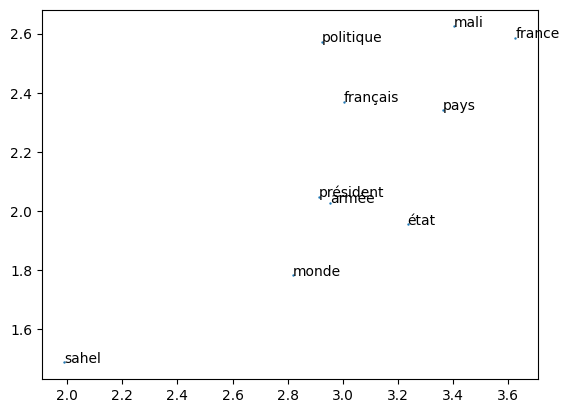

In [27]:
plt.scatter(df.V1.head(10), df.V2.head(10), s=0.5)
for i in range(10):
    plt.annotate(df.index[i], (df.V1[i], df.V2[i]))
plt.show()

----------------------

# Matrice de coocurrence

**Récupération des mots les plus cités**

In [28]:
articles = ['mali--www.egaliteetreconciliation.fr',
               'mali--french.presstv.ir',
               'mali--fr.sputniknews.africa',
               'france--www.fdesouche.com',
               'france--www.egaliteetreconciliation.fr',
               'france--french.presstv.ir',
               'france--fr.sputniknews.africa']

doc = articles[0]

kws = pd.read_csv(f"./data/Dashboard/kws/df_kws_occ_sans_france_mali----{doc}.csv")
df_subset_kws = kws.head(10)

print(df_subset_kws)

    Keywords  Nombre occurrences
0         an            0.007674
1       état            0.006127
2       pays            0.005740
3  militaire            0.004610
4  politique            0.004402
5      armée            0.004313
6  président            0.004223
7      grand            0.003926
8      force            0.003688
9    afrique            0.003539


**Création de la matrice**

In [29]:
#Création de la matrice vide
df = pd.DataFrame(index=df_subset_kws['Keywords'].tolist(), columns=df_subset_kws['Keywords'].tolist())

#On la remplie de 0
df = df.fillna(0)
print(df)

#On la remplie
for word1 in df_subset_kws['Keywords'].tolist() :
    for word2 in df_subset_kws['Keywords'].tolist() :
        if word1 in modele.wv.key_to_index and word2 in modele.wv.key_to_index :
            df.at[word1,word2] = int(words.similarity(word1, word2)*100)

# Supprimer les lignes où toutes les valeurs sont zéros
df = df.loc[(df != 0).any(axis=1)]

# Supprimer les colonnes où toutes les valeurs sont zéros
df = df.loc[:, (df != 0).any(axis=0)]


print(df)

fig = px.imshow(df, text_auto=True)
fig.show()

           an  état  pays  militaire  politique  armée  président  grand  \
an          0     0     0          0          0      0          0      0   
état        0     0     0          0          0      0          0      0   
pays        0     0     0          0          0      0          0      0   
militaire   0     0     0          0          0      0          0      0   
politique   0     0     0          0          0      0          0      0   
armée       0     0     0          0          0      0          0      0   
président   0     0     0          0          0      0          0      0   
grand       0     0     0          0          0      0          0      0   
force       0     0     0          0          0      0          0      0   
afrique     0     0     0          0          0      0          0      0   

           force  afrique  
an             0        0  
état           0        0  
pays           0        0  
militaire      0        0  
politique      0       

**Sauvegarde du data frame**

In [30]:
# df.to_csv('./data/Dashboard/kws/Word2VecMatrice/df_kws_word2vec_sans_france_mali----france--fr.sputniknews.africa.csv', index=False)